In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm
import numpy as np
import math as ma

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy import units as u
import astropy 

import pandas as pd

import loadSP as lsp
import cosmo
import halos
import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

In [2]:
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

def exp_formatter(x,pos):
    return format(x, '.2e')
expfmt  = FuncFormatter(exp_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.2669999897, Ob0=0.0445, name='myCosmo')
# Make sure we have halo information for this z... hop/...
z = 12.0
num = 43 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.

print("Using astropy cosmology: size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))

sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))
boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1]

Using astropy cosmology: size 325.03 kpc


In [5]:
locs, mass, bt, Z, PZ, PPF = lsp.loadSP(z)

In [6]:
baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
spAges = baseAge - bt/1e6
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))

min sp age 1.24 Myr
max sp age 180.15 Myr
min sp Z 5.00e-09 Solar
max sp Z 1.13e-01 Solar


In [7]:
# import importlib
# importlib.reload(lsp)
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
##
halosRawPos = lsp.loadHaloGrps(num) # Returns positions normalized to (-0.5, 0.5)
tbox = boxsizekpc
print("boxsize at z={:.2f} is {:.2f}".format(z,tbox))
halosPos = halosRawPos * tbox
len(halosRawPos)

boxsize at z=12.00 is 324.44


7103

In [9]:
arcPerKpc = astroPyCosmo.arcsec_per_kpc_comoving(z=9.5)
print('arcPerKpc Comoving:',arcPerKpc)
arcPerKpc = astroPyCosmo.arcsec_per_kpc_proper(z=9.5)
print('arcPerKpc Proper:',arcPerKpc)
kpcPerArcSec = cosmo.arcAtz(71,z=9.5,om=0.24, ol=1.0-0.24) # size of an arcsec at the specified reshift in kpc
print('kpcPerArcSec Proper:',1.0 / kpcPerArcSec)


Comoving: 0.020734679928940715 arcsec / kpc
Proper: 0.21771413925387748 arcsec / kpc


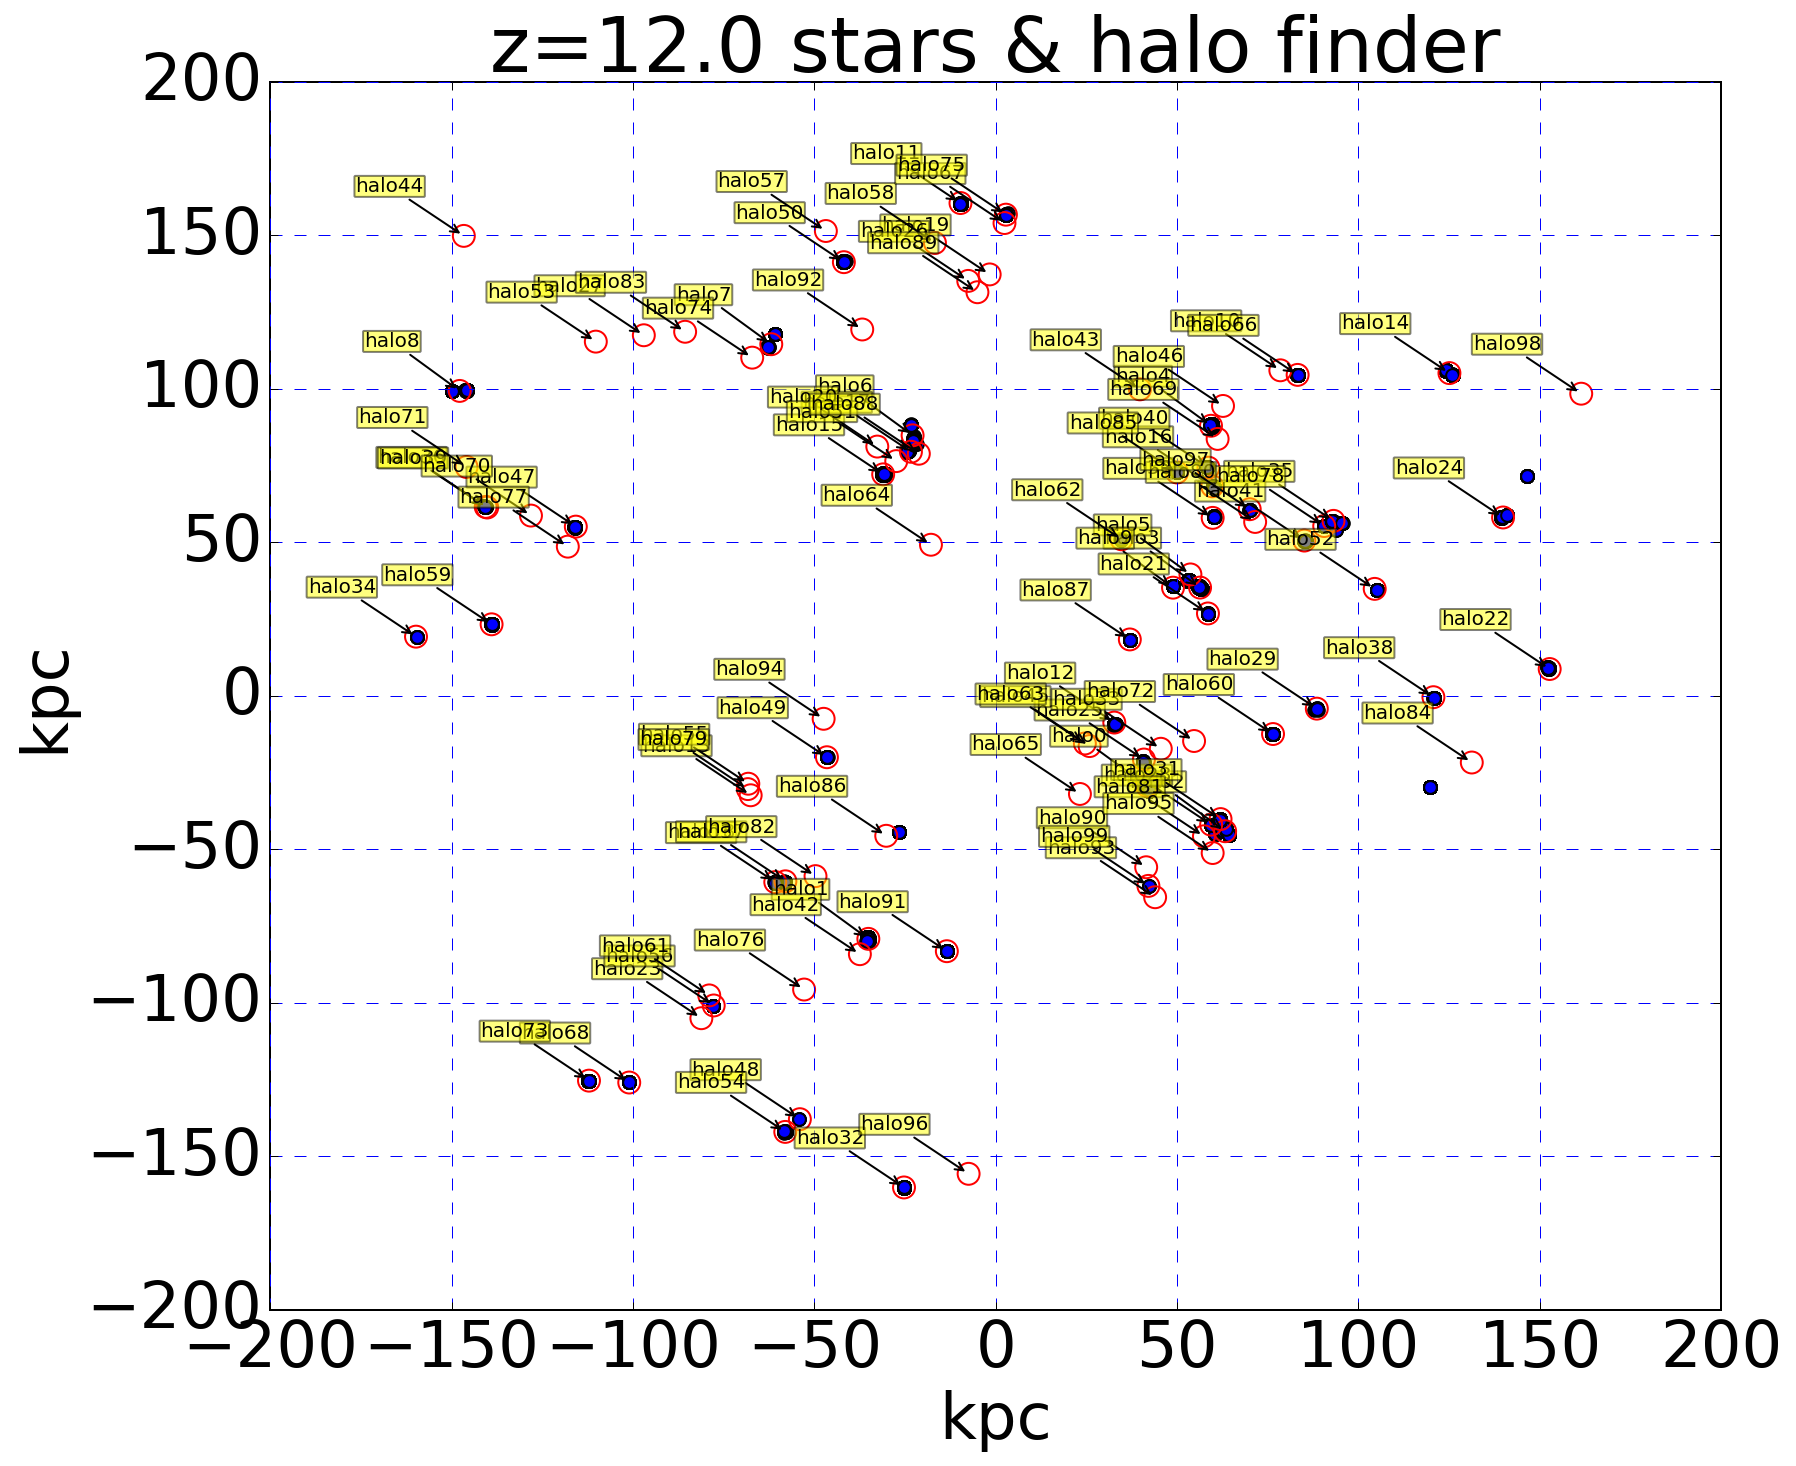

In [11]:
htp = 100
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0],locs[:,1],s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0],halosPos[:htp,1],s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0],halosPos[:htp,1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

In [78]:
# Remember, log age and flux for 1 M_sun
pop3Flux_14 = np.genfromtxt('pop3TE_14.0.gz',dtype=float, delimiter=',',names=True)
Zem7Flux_14 = np.genfromtxt('Zem7_14.0.gz',dtype=float, delimiter=',',names=True)
Zem5Flux_14 = np.genfromtxt('Zem5_14.0.gz',dtype=float, delimiter=',',names=True)
SB990004_14 = np.genfromtxt('SB990004_14.0.gz',dtype=float, delimiter=',',names=True)
SB99004_14  = np.genfromtxt('SB99004_14.0.gz',dtype=float, delimiter=',',names=True)
SB99008_14  = np.genfromtxt('SB99008_14.0.gz',dtype=float, delimiter=',',names=True)
SB9902_14   = np.genfromtxt('SB9902_14.0.gz',dtype=float, delimiter=',',names=True)
filternames = np.array(pop3Flux14).dtype.names[2::]

In [79]:
print(filternames) # Just the filter names, skipped "LogAge" and "Z"

('f360m', 'f162m', 'f300m', 'f356w', 'f480m', 'f444w', 'f460m', 'f210m', 'f200w', 'f115w', 'f070w', 'f140m', 'f150w', 'f430m', 'f410m', 'f090w', 'f250m', 'f277w', 'f182m', 'f335m', 'F606W_ACS', 'F105W_WFC3', 'F435W_ACS', 'F336W_WFC3', 'F850LP_ACS', 'F225W_WFC3', 'F160W_WFC3', 'F775W_ACS', 'F125W_WFC3', 'F098M_WFC3', 'F275W_WFC3', 'Ks', 'J', 'H')


In [80]:
pop3Flux_14['f115w'][0:10],np.log10(pop3Flux_14['f115w'])[0:10]
# np.ma.masked_less_equal(pop3Flux_14[filt],0.0)

(array([  4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199]),
 array([-198.31705209, -198.31705209, -198.31705209, -198.31705209,
        -198.31705209, -198.31705209, -198.31705209, -198.31705209,
        -198.31705209, -198.31705209]))

In [122]:
#
# Generate interpolating functions for each metallicity over the age range computed for that Z
# Do interpolation in log-log space... 
#
flux = {0:   {filt : interp1d(pop3Flux_14['LogAge'],
                              np.log10(np.ma.masked_less_equal(pop3Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       1e-7: {filt : interp1d(Zem7Flux_14['LogAge'],np.log10(np.ma.masked_less_equal(Zem7Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       1e-5: {filt : interp1d(Zem5Flux_14['LogAge'],np.log10(np.ma.masked_less_equal(Zem5Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       4e-4: {filt : interp1d(SB990004_14['LogAge'],np.log10(np.ma.masked_less_equal(SB990004_14[filt],0.0)),kind='linear') for filt in filternames},
       8e-3: {filt : interp1d(SB99008_14['LogAge'],np.log10(np.ma.masked_less_equal(SB99008_14[filt],0.0)),kind='linear') for filt in filternames},
       4e-3: {filt : interp1d(SB99004_14['LogAge'],np.log10(np.ma.masked_less_equal(SB99004_14[filt],0.0)),kind='linear') for filt in filternames},
       2e-2: {filt : interp1d(SB9902_14['LogAge'],np.log10(np.ma.masked_less_equal(SB9902_14[filt],0.0)),kind='linear') for filt in filternames}
       }

In [82]:
# CHECK ... ensure we have the correct values at the interpolated points... 
# We have different age ranges, spacing for the different types of flux files...
pop3Flux_14['LogAge'][0:5], Zem7Flux_14['LogAge'][0:5], SB99008_14['LogAge'][0:5] , SB9902_14['LogAge'][0:5] 

(array([ 4.   ,  6.004,  6.303,  6.479,  6.603]),
 array([ 4.  ,  4.05,  4.1 ,  4.15,  4.2 ]),
 array([ 4.    ,  6.3032,  6.6031,  6.7789,  6.9036]),
 array([ 4.    ,  6.3032,  6.6031,  6.7789,  6.9036]))

In [83]:
print(10**flux[0]['F225W_WFC3']([4.,6.004]), 10**flux[1e-7]['F225W_WFC3']([4.,4.05]))
print(10**flux[8e-3]['f115w']([4.,6.3032]), 10**flux[8e-3]['Ks']([4.,6.3032]))

[  1.07530000e-82   5.78390000e-83] [  1.37360000e-86   1.37360000e-86]
[  4.81890000e-199   4.81890000e-199] [  4.79370000e-089   7.90850000e-199]


In [84]:
print(pop3Flux14['F225W_WFC3'][0:2], Zem7Flux_14['F225W_WFC3'][0:2])
print(SB99008_14['f115w'][0:2] , SB99008_14['Ks'][0:2])  # Matches our interpolators ... 

[  1.07530000e-82   5.78390000e-83] [  1.37360000e-86   1.37360000e-86]
[  4.81890000e-199   4.81890000e-199] [  4.79370000e-089   7.90850000e-199]


# The Algo

In [ ]:
redshifts    = [5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
haloFiles    = [241, 215, 191, 152, 136, 121, 108, 97, 84, 73, 58, 43, 33, 26, 20, 16]

In [ ]:
#
# HERE's the main loop
#
#
filename = 'haloFluxes_z_' + str(z) + "_.txt" 
outfile = []
# for indx,h in enumerate(halosPos):
for indx in np.arange(10):
    halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,indx,10.0)
    if (len(halospmass) == 0):
        continue
    print()
    print("Working on halo {} with {} star particles.".format(indx,len(halospmass)))
    halospZ  = halospZ * 0.02 # back to mass fraction
    halospPZ = halospPZ * 0.02

    haloFiltTots = dict.fromkeys([filt for filt in filternames], 0.0) # Initialize filter totals for this halo
    headerStr  = 'indx, M/M_sun, '
    headerStr += ', '.join([f for f in haloFiltTots.keys()])
    Zs = sorted(flux.keys())
    for spZ,spAge,spMass in zip(halospZ,np.log10(halospages*1e6),halospmass): # Z,PZ are now mass fractions, as in flux files
        for filt in filternames:
            theFluxFunc = interp1d(np.log10([aZ for aZ in Zs]),          # x = Log of each Z for which we have a table... 
                                   [flux[aZ][filt](spAge) for aZ in Zs], # y = Log of flux at each Z at age = spAge
                                   kind='linear')
            # So now theFluxFunc is f(log10(Z))=log10(flux) at spAge
            theFluxForStar = 10**theFluxFunc(np.log10(spZ))
            if theFluxForStar > 1e-100:
                haloFiltTots[filt] += theFluxForStar * spMass
        # Should I include the halo's total mass??
        # How to append to haloFiltTots

    print("Appending line to outfile...")

    # Compute aveZ
    aveZ = np.sum(halospmass * halospZ)/np.sum(halospmass)
    aveZ = aveZ / 0.02 # Back to solar units... 
    avePZ = np.sum(halospmass * halospPZ)/np.sum(halospmass)
    avePZ = avePZ / 0.02 # Back to solar units... 
    
    values = np.array([i for i in haloFiltTots.values()])
    aLine = [indx] + [aveZ] + [avePZ] + [np.sum(halospmass)] + values.tolist()
    outfile.append(aLine)

print("Writing flux file...")
np.savetxt(filename, outfile, fmt='%.4e', delimiter=', ', header=headerStr) # (values) to get row-wise write


Working on halo 0 with 5135 sps
